## Predicting $\Gamma$-phonon with VVN given CIF files
### Getting started

In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import torch
from torch_geometric.loader import DataLoader
import pandas as pd
from ase.visualize.plot import plot_atoms
from ase.io import read
from utils.utils_data import generate_data_dict
from utils.utils_model import GraphNetwork_VVN, load_model
from utils.utils_plot import generate_dataframe, plot_gphonon
from utils.utils_qpts import get_qpts
from config_file import pretrained_model_dict
torch.set_default_dtype(torch.float64)
if torch.cuda.is_available():
    device = 'cuda'
else:
    device = 'cpu'
palette = ['#43AA8B', '#F8961E', '#F94144', '#277DA1']
sub = str.maketrans("0123456789", "₀₁₂₃₄₅₆₇₈₉")
color_set = ['g', 'y', 'r']
colors = dict(zip(color_set, palette[:len(color_set)]))
cmap = mpl.colors.LinearSegmentedColormap.from_list('cmap', [palette[k] for k in [0,2,1]])

###     Model Parameter

In [2]:
option = 'vvn' # use kMVN model
descriptor = 'mass' # use mass as descriptor
use_pretrained = True
pretrained_name = pretrained_model_dict[option] # pretrained model uses 'mass' as descriptor
r_max = 4.0 # cutoff radius (we used 4.0 Angstrom in the paper)
factor = 1000   # factor to scale the predicted band gap (do not need to change)

### Data preparation
We search cif files in cif_folder, and load them with high-symmetry momentum path suggested by SeekPath. 

In [3]:
cif_folder = './cif_folder'
cif_files = sorted([f for f in os.listdir(cif_folder) if f.endswith('.cif')])
data = pd.DataFrame({})
for cif_file in cif_files:
    d = dict()
    atoms = read(os.path.join(cif_folder, cif_file))
    material_id = cif_file.replace('.cif', '')
    numb = len(atoms)

    qpts_dict = get_qpts(atoms, nongamma=True)
    qpts = np.array(qpts_dict['qpts'])
    qticks = qpts_dict['qticks']
    d['id'] = material_id
    d['structure'] = [atoms]
    d['qpts'] = [qpts]
    d['qticks'] = [qticks]
    d['real_band'] = [np.zeros((len(qpts), 3*numb))]    # Since we do not have band structure data, we set it to zero matrix of shape (len(qpts), 3*numb)
    dfn = pd.DataFrame(data = d)
    data = pd.concat([data, dfn], ignore_index = True)

data_dict = generate_data_dict(data, r_max, descriptor=descriptor, option=option, factor=factor)

/home/rokabe/anaconda3/envs/phonon/lib/python3.9/site-packages/seekpath/hpkot/__init__.py:286: EdgeCaseWarning: hR lattice, but sqrt(3)a almost equal to sqrt(2)c
  warnings.warn(
/home/rokabe/anaconda3/envs/phonon/lib/python3.9/site-packages/seekpath/hpkot/__init__.py:352: EdgeCaseWarning: aP lattice, but the k_alpha3 angle is almost equal to 90 degrees
  warnings.warn(
/home/rokabe/anaconda3/envs/phonon/lib/python3.9/site-packages/seekpath/hpkot/__init__.py:357: EdgeCaseWarning: aP lattice, but the k_beta3 angle is almost equal to 90 degrees
  warnings.warn(
/home/rokabe/anaconda3/envs/phonon/lib/python3.9/site-packages/seekpath/hpkot/__init__.py:362: EdgeCaseWarning: aP lattice, but the k_gamma3 angle is almost equal to 90 degrees
  warnings.warn(
  0%|          | 0/5 [00:00<?, ?it/s]/data1/rokabe/phonon/phonon_prediction/utils/utils_data.py:293: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requi

In [4]:
# Review the data
data

,id,structure,qpts,qticks,real_band
0,mp-149,"(Atom('Si', [0.0, 0.0, 0.0], index=0), Atom('S...","[[0.0, 0.0, 0.0], [0.029411764705882353, 0.029...","[\Gamma, , , , , , , , , , , , , , , , , T, H_...","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,..."
1,mp-2059,"(Atom('Nb', [0.0, 0.0, 8.8542772787448], index...","[[0.0, 0.0, 0.0], [0.05555555555555555, 0.0, 0...","[\Gamma, , , , , , , , , X, Y, , , , , , , , ,...","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,..."
2,mp-2534,"(Atom('Ga', [0.0, 0.0, 0.0], index=0), Atom('G...","[[0.0, 0.0, 0.0], [0.029411764705882353, 0.029...","[\Gamma, , , , , , , , , , , , , , , , , T, H_...","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,..."
3,mp-30,"(Atom('Cu', [0.0, 0.0, 0.0], index=0), Atom('C...","[[0.0, 0.0, 0.0], [0.0, 0.05555555555555555, 0...","[\Gamma, , , , , , , , , X, , , , , , , , , M,...","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,..."
4,mp-7577,"(Atom('Co', [0.639511351248549, 0.639511351248...","[[0.0, 0.0, 0.0], [0.029411764705882353, 0.029...","[\Gamma, , , , , , , , , , , , , , , , , T, H_...","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,..."


### Transform the data into the input data format. 
Get the test data with the proper format. 

In [5]:
te_num = len(data_dict)
idx_te = range(te_num)
data_set = torch.utils.data.Subset(list(data_dict.values()), idx_te)
te_set = torch.utils.data.Subset(data_set, idx_te)
te_loader = DataLoader(te_set, batch_size = 1)

### load pre-trained model
Load the pre-trained model from the archive. Our code automatically load the hyperparameters and the learned weights from the .torch file. 

In [6]:

model_name = pretrained_name # model name (load from pretrained model)
save_name = f'./models/{model_name}'   
model_file = save_name + '.torch'
model, conf_dict, history, s0 = load_model(GraphNetwork_VVN, model_file, device)
num_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print('number of parameters: ', num_params)

Loading model from: ./models/vvn_240922-214607.torch


/home/rokabe/anaconda3/envs/phonon/lib/python3.9/site-packages/torch/jit/_check.py:172: UserWarning: The TorchScript type system doesn't support instance-level annotations on empty non-base types in `__init__`. Instead, either 1) use a type annotation in the class body, or 2) wrap the type in `torch.jit.Attribute`.
  warnings.warn("The TorchScript type system doesn't support "


number of parameters:  380824


### Predict the phonon band structure
We use the pre-trained model to predict phonon of the given cif files. 

In [7]:
# Generate Data Loader and then Data Frame
df_te = generate_dataframe(model, te_loader, None, device, option, factor)  

  0%|          | 0/5 [00:00<?, ?it/s]/data1/rokabe/phonon/phonon_prediction/utils/utils_plot.py:208: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df = pd.concat([df, df0], ignore_index=True)
100%|██████████| 5/5 [00:02<00:00,  1.67it/s]


Text(0.5, 1.0, '[mp-149] Si8: $\\Gamma$-phonon')

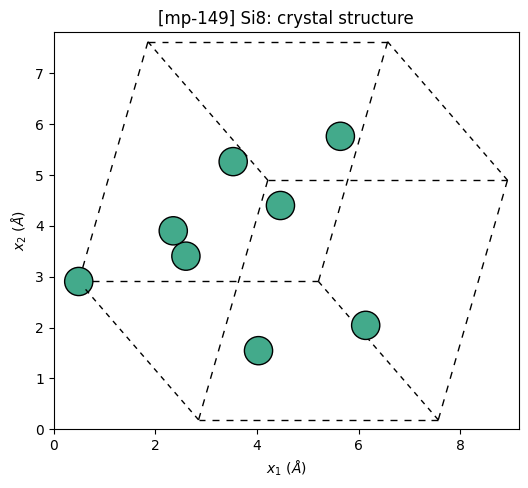

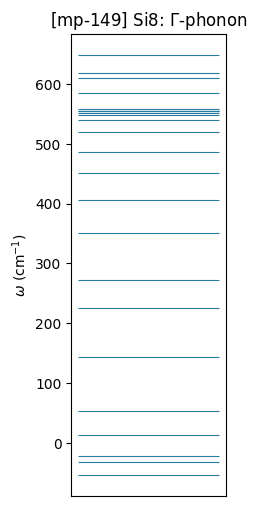

In [8]:
# Set the index for which structure to plot from the dataframe
idx = 0  #TODO: change this index to plot a different structure (0~len(data)-1)

# [0] Load the structure and other data for the selected material
real = None  # Set real data to None if not available
row_df = df_te.iloc[idx]  # Get the row for the selected structure in the test set
material_id = row_df['id']  # Extract the material ID
pred = row_df['pred']  # Extract the predicted band structure
row_data = data[data['id'] == material_id]  # Get the row for the selected structure in the data dataframe
qticks = row_data['qticks'].item()  # Get the q-ticks for this material
struct =row_data['structure'].item()  # Get the structure of the material from the dataframe
symbols = np.unique(list(struct.symbols))  # Get unique atomic symbols from the structure
numb = len(struct)  # Get the number of atoms in the structure
z = dict(zip(symbols, range(numb)))  # Create a mapping from atomic symbols to indices

# [1] Create a plot of the atomic structure using matplotlib
fig, ax = plt.subplots(figsize=(6,6))
norm = plt.Normalize(vmin=0, vmax=numb-1)  # Normalize the color map for atoms
color = [mpl.colors.to_hex(k) for k in cmap(norm([z[j] for j in list(struct.symbols)]))]  # Assign colors based on atomic symbols
plot_atoms(struct, ax, radii=0.25, colors=color, rotation=('30x,30y,0z'))  # Plot the atoms with radii and rotation
ax.set_xlabel(r'$x_1\ (\AA)$')  # Set x-axis label with LaTeX formatting for Angstroms
ax.set_ylabel(r'$x_2\ (\AA)$')  # Set y-axis label with LaTeX formatting
ax.set_title(f"[{material_id}] {struct.get_chemical_formula()}: crystal structure")  

# [2] Plot the predicted phonon band structure
# Plot the predicted band structure with custom function
fig, ax = plt.subplots(figsize=(2,6))
plot_gphonon(ax, real, pred, palette[-1], lwidth=0.8, plot_real=False, ylabel=True)  # Plot prediction without real data
ax.set_title(f"[{material_id}] {struct.get_chemical_formula()}: $\Gamma$-phonon")  
